# Steam (Environment - Agent)

In [1]:
# Basic import
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import norm
import pdb
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Dot, Concatenate
from tensorflow.keras.models import Model
tf.config.experimental_run_functions_eagerly(True)
print(tf.__version__)

2.0.0


## Environment

In [2]:
class Environment:
    def __init__(self, nb_films, nb_users, 
                 context_size = 2,
                 displayed_users_embedding_size = 2, #used for the features vector
                 displayed_games_embedding_size = 2, #used for the features vector
                 noise_size = 3,
                 rating_probability = 0.5,
                 std_dev_playtime = 0.15,
                 refund_threshold = 0.1,
                 seed=None):     
        self._rng = np.random.RandomState(seed)
        self._rating_probability = rating_probability 
        self._std_dev_playtime = std_dev_playtime
        self._refund_threshold = refund_threshold
        #-------------------------------------------------------#
        self._nb_games = nb_games
        self._nb_users = nb_users
        self._p = context_size # size of user, size of game
        self._displayed_users_embedding_size = displayed_users_embedding_size
        self._displayed_games_embedding_size = displayed_games_embedding_size
        self._noise_size = noise_size
        #-------------------------------------------------------
        self.user_mean = np.ones(self._p)
        self.user_var = np.ones(self._p)
        self.game_mean = np.ones(self._p)
        self.game_var = np.ones(self._p)
        #-------------------------------------------------------#
        self.finish = False # True = all games have been played
    
    def step(self):
        if self.finish == True or self._available_games.sum() == 0: 
            # all players played all games
            self.finish = True
            print("All games played reset the environment")
            return 0, 0, self.finish
        
        user = self.get_next_user() # pick a user
        available_games = np.where(self._available_games[user] == 1)[0]
        optimal_reward = np.max(self._reward_matrix[user,available_games])
        return user, available_games, optimal_reward, self.finish
    
    def get_next_user(self):
        user = self._rng.randint(0, self._nb_users)
        if np.sum(self._available_games[user,:]) > 0: 
            # still some games to play for user
            return user
        else: 
            # all games played for the current user
            # find a random player between the ones who have some games left to play
            row,cols = np.where(self._available_games == 1)
            return self._rng.choice(row)
    
    def update(self, user, game):
        reward = self._reward_matrix[user, game]
        if self._rated[user, game]:
            rating = (self._rating_matrix[user, game] * 4) + 1
        else:
            rating = 0
        self._available_games[user, game] = 0
        return reward, rating
    
    def reset(self):
        self.finish = False
        self._users = self._rng.normal(loc=self.user_mean,
                                                scale=self.user_var,
                                                size=(self._nb_users, self._p))
        self._games = self._rng.normal(loc=self.game_mean,
                                                scale=self.game_var,
                                                size=(self._nb_games, self._p))
        
        z_mean = self.user_mean.dot(self.game_mean)
        z_var = self.user_var.dot(self.game_var) + self.user_var.dot(np.square(self.game_mean)) + \
                self.game_var.dot(np.square(self.user_mean))
        z = norm(z_mean, np.sqrt(z_var))
        self.z_cut_points = z.ppf([0.2, 0.4, 0.6, 0.8]) # buckets
        
        self._available_games = np.ones((nb_users, nb_games))
        # rating generation based on (user ∙ game)
        self._rating_matrix = np.zeros((nb_users, nb_games))     
        for i in range(self._rating_matrix.shape[0]):
            for j in range(self._rating_matrix.shape[1]):
                real_score = self._users[i].dot(self._games[j])
                self._rating_matrix[i, j] = np.searchsorted(self.z_cut_points, real_score) / 4
        # playtime generation
        # for simulation purposes, such playtime (always > 0) is based on the similarity 
        # between the user profile and the game (i.e. like a reward) + some noise
        # and some non-linear function (i.e. abs + clip)
        self._playtime_matrix = deepcopy(self._rating_matrix)
        self._playtime_matrix += self._rng.normal(loc = 0.0, scale = self._std_dev_playtime, size = (nb_users, nb_games))
        self._playtime_matrix = np.clip(np.abs(self._playtime_matrix), 0, 1)
        # reward matrix generation
        self._reward_matrix = np.zeros((nb_users, nb_games))
        self._rated = self._rng.binomial(1, self._rating_probability, size=(nb_users, nb_games))
        for i in range(self._reward_matrix.shape[0]):
            for j in range(self._reward_matrix.shape[1]):
                if self._playtime_matrix[i, j] < self._refund_threshold:
                    self._reward_matrix[i, j] = self._playtime_matrix[i, j]
                else:
                    if self._rated[i, j] == 1:
                        self._reward_matrix[i, j] = self._rating_matrix[i, j]
                    else:
                        self._reward_matrix[i, j] = self._playtime_matrix[i, j] / np.sum(self._playtime_matrix[i, :])

        users = deepcopy(self._users)
        return users

    def get_feature_vector(self, user, game):
        user_embedding = self._users[user]
        game_embedding = self._games[game]
        
        if self._displayed_users_embedding_size + self._displayed_games_embedding_size > 0:
            variables = np.array([user_embedding[:self._displayed_users_embedding_size],
                                  game_embedding[:self._displayed_games_embedding_size]])

            if self._noise_size > 0:
                noise = self._rng.normal(loc=np.ones(self._noise_size),
                                         scale=np.ones(self._noise_size),
                                         size=self._noise_size)
                
                variables = np.append(variables, noise)
                
        return variables
        
        
    def reset_seed(self, seed=None):
        self._rng = np.random.RandomState(seed)
        return

## Random agent

In [3]:
class RandomAgent:
    def __init__(self, seed = None):
        self._rng = np.random.RandomState(seed)
    
    def act(self, available_games):
        action = self._rng.choice(available_games)
        return action

## Experiment

In [4]:
# Basic parameter
nb_users = 30 #number of users in the context = 30
nb_games = 10 #number of games in the context = 10
context_size = 2 #number of different game categories = 2

In [5]:
# Creating the environment
env = Environment(nb_games,nb_users,context_size,seed=2020,rating_probability=0.7)
env.reset() # reset and initilize the environment

array([[-0.76884571,  1.07555227],
       [-0.1306297 ,  0.34856983],
       [ 0.10688437, -0.27410098],
       [ 0.93884557,  1.06451384],
       [ 1.41011295,  0.42711751],
       [ 0.19866638,  2.31203519],
       [ 2.27469887, -0.2143576 ],
       [ 1.31371941, -0.44482142],
       [ 0.6310387 ,  0.23077342],
       [ 1.3926161 ,  1.05729383],
       [ 3.08997884,  1.04197131],
       [ 0.95165928,  0.48684608],
       [ 0.91541072, -0.21545008],
       [-0.41293073, -0.48691055],
       [ 1.38222486,  1.937673  ],
       [ 2.77267804,  1.87882801],
       [ 1.33171912,  0.69396433],
       [ 2.24026615,  0.78437316],
       [ 1.15592948,  1.09805553],
       [ 1.83209585,  3.04520542],
       [ 0.68318608, -0.31283291],
       [-0.75445746,  1.10209408],
       [-0.36150208,  1.48178488],
       [ 0.79167126,  0.90813649],
       [ 1.70268816,  1.10365506],
       [ 1.62123638,  1.95411497],
       [ 3.03781352,  0.51554878],
       [ 1.2071549 ,  2.64424216],
       [ 0.5117926 ,

In [6]:
# Creating the agent
agent = RandomAgent(2020)

We run the experiment and generate some historical data.

In [7]:
# Running several trials
nb_iteration = 100 #how many trials
reward_matrix = np.zeros((nb_users, nb_games))
rating_matrix = np.zeros((nb_users, nb_games))
users = list()
games = list()
rewards = list()
for i in range(nb_iteration):
    user, available_games, _, finish = env.step()
    if finish:
        print("Maybe too many trial try to reduce and reset the environment")
        break
    choosen_game = agent.act(available_games)
    reward, rating = env.update(user, choosen_game)
    users.append(user)
    games.append(choosen_game)
    rewards.append(reward)
    reward_matrix[user, choosen_game] = reward
    rating_matrix[user, choosen_game] = rating
    print("user = {}, available games = {}, choosen_game = {}".format(user,available_games,choosen_game))
    print("reward = {}\n".format(reward))

user = 4, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 0
reward = 0.25

user = 1, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 8
reward = 0.15092829746890254

user = 12, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 3
reward = 0.08775769232379384

user = 3, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 6
reward = 0.09724859800596905

user = 1, available games = [0 1 2 3 4 5 6 7 9], choosen_game = 3
reward = 0.25

user = 0, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 3
reward = 0.5

user = 29, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 7
reward = 0.11724587932024325

user = 12, available games = [0 1 2 4 5 6 7 8 9], choosen_game = 9
reward = 0.09752073411957192

user = 6, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 0
reward = 0.08454433019099539

user = 15, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 0
reward = 0.5

user = 7, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 8
reward = 0.052

In [8]:
print("reward matrix: \n", str(reward_matrix))
print("rating matrix: \n", str(rating_matrix))

reward matrix: 
 [[0.         0.         0.09883591 0.5        0.         0.
  0.15731846 0.25       0.         0.        ]
 [0.         0.         0.         0.25       0.         0.
  0.25       0.         0.1509283  0.        ]
 [0.0827172  0.         0.         0.02537533 0.         0.03269443
  0.         0.019173   0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.0972486  0.5        0.         0.25      ]
 [0.25       0.10036821 0.         0.         0.         0.
  0.         0.         0.07247928 0.25      ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.03847896]
 [0.08454433 0.         1.         0.         1.         0.
  0.05875463 0.5        0.         0.        ]
 [0.25       0.         0.         0.06849893 0.         0.
  0.07317941 0.         0.05228926 0.        ]
 [0.25       0.         0.         0.25       0.         0.
  0.03761376 0.         0.         0.25      ]
 [0.        

## Regression model

In [9]:
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user, max_game):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user,
                                        input_length=1,
                                        name='user_embedding')
        self.game_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_game,
                                        input_length=1,
                                        name='game_embedding')
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        game_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        game_vecs = self.flatten(self.game_embedding(game_inputs))
        
        y = self.dot([user_vecs, game_vecs])
        return y

## Deep regression model

In [10]:
class DeepRegressionModel(Model):

    def __init__(self, embedding_size, max_user, max_game):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user,
                                        input_length=1,
                                        name='user_embedding')
        self.game_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_game,
                                        input_length=1,
                                        name='game_embedding')
        
        self.flatten = Flatten()
        self.concat = Concatenate()
        
        self.dropout = Dropout(0.9)
        self.dense1 = Dense(16, activation="relu")
        self.dense2 = Dense(8, activation="tanh")
        
    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        game_inputs = inputs[1]
        feature_inputs = inputs[2]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        game_vecs = self.flatten(self.game_embedding(game_inputs))
        
        input_vecs = self.concat([user_vecs, game_vecs, self.flatten(feature_inputs)])
        
        y = self.dropout(input_vecs, training=training)
        y = self.dense1(y)
        y = self.dense2(y)
        
        return y

## Embedding agent

In [11]:
class EmbeddingAgent:
    def __init__(self, X, Y, deepRegression=False):
        if deepRegression:
            self._model = DeepRegressionModel(64, nb_users, nb_games)
        else:
            self._model = RegressionModel(64, nb_users, nb_games)
        self._model.compile(optimizer="adam", loss='mae')
        self._model.fit(X, Y,
                  batch_size=64, epochs=100, validation_split=0.1,
                  shuffle=True)
        self._user_embeddings = self._model.get_weights()[0]
        self._game_embeddings = self._model.get_weights()[1]
    
    def act(self, user, available_games):
        user_embedding = self._user_embeddings[user]
        dot_products = self._game_embeddings @ user_embedding
        user_embedding_norm = np.linalg.norm(user_embedding)
        all_item_norms = np.linalg.norm(self._game_embeddings, axis=1)
        norm_products = user_embedding_norm * all_item_norms
        sims = dot_products / (norm_products)
        sims = np.argsort(sims)[::-1]
        mask = np.in1d(sims, available_games)
        sims = sims[mask]
        return sims[0]

In [12]:
deepRegression = False

users = np.array(users)
games = np.array(games)
rewards = np.array(rewards)

if deepRegression:
    features = []
    for i in range(len(users)):
        features.append(env.get_feature_vector(users[i], games[i]))
    features = np.float64(features)
    agent = EmbeddingAgent([users, games, features], rewards, deepRegression=deepRegression)
else:
    agent = EmbeddingAgent([users, games], rewards, deepRegression=deepRegression)

Train on 90 samples, validate on 10 samples
Epoch 1/100
90/90 [==============================] - 0s 501us/sample - loss: 0.3330 - val_loss: 0.2569
Epoch 2/100
90/90 [==============================] - 0s 344us/sample - loss: 0.3307 - val_loss: 0.2568
Epoch 3/100
90/90 [==============================] - 0s 406us/sample - loss: 0.3287 - val_loss: 0.2567
Epoch 4/100
90/90 [==============================] - 0s 334us/sample - loss: 0.3268 - val_loss: 0.2566
Epoch 5/100
90/90 [==============================] - 0s 332us/sample - loss: 0.3249 - val_loss: 0.2565
Epoch 6/100
90/90 [==============================] - 0s 373us/sample - loss: 0.3230 - val_loss: 0.2565
Epoch 7/100
90/90 [==============================] - 0s 353us/sample - loss: 0.3210 - val_loss: 0.2564
Epoch 8/100
90/90 [==============================] - 0s 439us/sample - loss: 0.3189 - val_loss: 0.2562
Epoch 9/100
90/90 [==============================] - 0s 332us/sample - loss: 0.3168 - val_loss: 0.2561
Epoch 10/100
90/90 [=========

90/90 [==============================] - 0s 358us/sample - loss: 0.0485 - val_loss: 0.1868
Epoch 80/100
90/90 [==============================] - 0s 368us/sample - loss: 0.0465 - val_loss: 0.1865
Epoch 81/100
90/90 [==============================] - 0s 375us/sample - loss: 0.0438 - val_loss: 0.1865
Epoch 82/100
90/90 [==============================] - 0s 366us/sample - loss: 0.0420 - val_loss: 0.1861
Epoch 83/100
90/90 [==============================] - 0s 366us/sample - loss: 0.0399 - val_loss: 0.1853
Epoch 84/100
90/90 [==============================] - 0s 360us/sample - loss: 0.0383 - val_loss: 0.1846
Epoch 85/100
90/90 [==============================] - 0s 383us/sample - loss: 0.0366 - val_loss: 0.1842
Epoch 86/100
90/90 [==============================] - 0s 309us/sample - loss: 0.0350 - val_loss: 0.1837
Epoch 87/100
90/90 [==============================] - 0s 379us/sample - loss: 0.0330 - val_loss: 0.1830
Epoch 88/100
90/90 [==============================] - 0s 394us/sample - loss:

## Collaborative filtering agent

In [9]:
def similarity(ratings):
    # get the rewards for each user
    r_user = (ratings>0.0).sum(axis=1)
    
    # get the average reward for each user
    m_user = np.divide(ratings.sum(axis=1) , r_user, where=r_user!=0)
    
    # recentered rewards over user's average
    ratings_ctr = ratings.T - ((ratings.T!=0) * m_user)
    ratings_ctr = ratings_ctr.T
    
    # Gram's matrix
    sim = ratings_ctr.dot(ratings_ctr.T) 
    
    return sim

def phi(x):
    return np.maximum(x,0)

In [10]:
class CollaborativeFilteringAgent:
    def __init__(self, nb_users, nb_games, rating_matrix = None):
        if rating_matrix == None:
            self._rating_matrix = np.zeros((nb_users, nb_games))
        else:
            self._rating_matrix = rating_matrix
        self.compute_matrix()
    
    def compute_matrix(self):
        sim = similarity(self._rating_matrix)
        numerator = phi(sim).dot(self._rating_matrix)
        denominator = phi(sim).dot(self._rating_matrix>0)
        self._pred_ratings = np.divide(numerator,denominator,where = denominator!=0)
    
    def update(self, user, game, rating):
        self._rating_matrix[user, game] = rating
        self.compute_matrix()
    
    def act(self, user, available_games):
        sims = self._pred_ratings[user]
        sims = np.argsort(sims)[::-1]
        mask = np.in1d(sims, available_games)
        sims = sims[mask]
        return sims[0]

## Measuring performances

In [11]:
prev_env = deepcopy(env)

In [20]:
nb_iteration = 100
nb_exp = 100
#---------------#
regret = np.zeros(nb_exp)
cum_regret = np.zeros((nb_exp, nb_iteration))

for t in range(nb_exp):
    env = deepcopy(prev_env)
    env.reset_seed()
    regrets = np.zeros(nb_iteration)
    agent = CollaborativeFilteringAgent(nb_users, nb_games)
    for i in range(nb_iteration):
        user, available_games, optimal_reward, finish = env.step()
        if finish:
            print("Maybe too many trial try to reduce and reset the environment")
            break
        choosen_game = agent.act(user, available_games)
        reward, rating = env.update(user, choosen_game)
        agent.update(user, choosen_game, rating)
        regrets[i] = optimal_reward - reward
        print("user = {}, available games = {}, choosen_game = {}".format(user,available_games,choosen_game))
        print("reward = {}, optimal reward = {}\n".format(reward, optimal_reward))
    print("END OF EXPERIMENT #" + str(t) + "\n\n")
    cum_regret[t] = np.cumsum(regrets)
    regret[t] = np.sum(regrets)

user = 5, available games = [0 1 2 3 4 5 6 7 8], choosen_game = 8
reward = 0.18549934381515992, optimal reward = 0.75

user = 9, available games = [0 1 2 3 4 5 6 8], choosen_game = 8
reward = 0.75, optimal reward = 0.75

user = 5, available games = [0 1 2 3 4 5 6 7], choosen_game = 7
reward = 0.1968325332652559, optimal reward = 0.75

user = 0, available games = [0 1 4 5 8 9], choosen_game = 1
reward = 0.0698464575777852, optimal reward = 0.25

user = 28, available games = [5 6 7 8], choosen_game = 8
reward = 0.5, optimal reward = 0.5

user = 16, available games = [0 1 4 5], choosen_game = 5
reward = 0.5, optimal reward = 1.0

user = 6, available games = [1 3 5 8 9], choosen_game = 9
reward = 0.5, optimal reward = 0.5

user = 2, available games = [1 2 4 6 8 9], choosen_game = 9
reward = 0.25, optimal reward = 0.25

user = 10, available games = [0 1 5 7 8 9], choosen_game = 9
reward = 0.08985667216755154, optimal reward = 1.0

user = 0, available games = [0 4 5 8 9], choosen_game = 0
re

user = 28, available games = [5 6 7 8], choosen_game = 8
reward = 0.5, optimal reward = 0.5

user = 5, available games = [0 1 2 3 4 5 6 7 8], choosen_game = 8
reward = 0.18549934381515992, optimal reward = 0.75

user = 9, available games = [0 1 2 3 4 5 6 8], choosen_game = 8
reward = 0.75, optimal reward = 0.75

user = 28, available games = [5 6 7], choosen_game = 7
reward = 0.5, optimal reward = 0.5

user = 23, available games = [0 1 2 4 5 6 7 8], choosen_game = 8
reward = 0.5, optimal reward = 0.5

user = 22, available games = [2 3 4 5 6 8 9], choosen_game = 9
reward = 0.0, optimal reward = 0.5

user = 15, available games = [2 3 4 6 8 9], choosen_game = 9
reward = 0.5, optimal reward = 1.0

user = 9, available games = [0 1 2 3 4 5 6], choosen_game = 6
reward = 0.12051981746300396, optimal reward = 0.75

user = 24, available games = [0 3 4 5 6 7 9], choosen_game = 9
reward = 0.05610844731366314, optimal reward = 0.75

user = 18, available games = [0 1 2 7], choosen_game = 7
reward = 0

user = 13, available games = [0 1 2 3], choosen_game = 3
reward = 0.0, optimal reward = 0.12880706738551514

user = 6, available games = [1], choosen_game = 1
reward = 0.5, optimal reward = 0.5

user = 12, available games = [1], choosen_game = 1
reward = 0.09703860238483973, optimal reward = 0.09703860238483973

user = 23, available games = [0 1 5], choosen_game = 1
reward = 0.5, optimal reward = 0.5

user = 5, available games = [0 2 3], choosen_game = 3
reward = 0.75, optimal reward = 0.75

user = 14, available games = [0 6], choosen_game = 0
reward = 0.06957330382673763, optimal reward = 0.25

user = 10, available games = [0], choosen_game = 0
reward = 0.037227631493987605, optimal reward = 0.037227631493987605

user = 8, available games = [1 2], choosen_game = 2
reward = 0.25, optimal reward = 0.25

user = 26, available games = [0 1 5 6], choosen_game = 1
reward = 0.75, optimal reward = 0.75

user = 8, available games = [1], choosen_game = 1
reward = 0.25, optimal reward = 0.25

use

user = 4, available games = [2 3 4 5], choosen_game = 5
reward = 0.09779161056218512, optimal reward = 1.0

user = 9, available games = [0 1 2 3 4], choosen_game = 4
reward = 0.18704792634109824, optimal reward = 0.18704792634109824

user = 20, available games = [0 1 2], choosen_game = 1
reward = 0.25, optimal reward = 0.5

user = 1, available games = [0], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 15, available games = [2], choosen_game = 2
reward = 1.0, optimal reward = 1.0

user = 26, available games = [0 1 2 5 6], choosen_game = 2
reward = 0.1386636381100085, optimal reward = 0.75

user = 9, available games = [0 1 2 3], choosen_game = 3
reward = 0.020679851941934918, optimal reward = 0.11039830526475555

user = 21, available games = [0 1 2 3 4 5 6], choosen_game = 6
reward = 0.026867964517055448, optimal reward = 0.5

user = 5, available games = [0 1 2 3 4 5], choosen_game = 5
reward = 0.75, optimal reward = 0.75

user = 2, available games = [1 2 4], choosen_game

user = 27, available games = [0 1 3 7 8], choosen_game = 8
reward = 1.0, optimal reward = 1.0

user = 19, available games = [0 1 2 4 6 7], choosen_game = 7
reward = 0.13498147251157622, optimal reward = 1.0

user = 24, available games = [0 3 4 5 6], choosen_game = 6
reward = 0.08646263661787984, optimal reward = 0.25

user = 7, available games = [1 2], choosen_game = 1
reward = 0.25, optimal reward = 0.25

user = 17, available games = [1 2 3 5 6], choosen_game = 5
reward = 0.09107987854045961, optimal reward = 1.0

user = 4, available games = [2 3 4], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 13, available games = [0 1 2 3], choosen_game = 3
reward = 0.0, optimal reward = 0.12880706738551514

user = 2, available games = [1 2], choosen_game = 2
reward = 0.1398480103658174, optimal reward = 0.1398480103658174

user = 28, available games = [5], choosen_game = 5
reward = 0.5, optimal reward = 0.5

user = 0, available games = [4], choosen_game = 4
reward = 0.02601653400609

user = 14, available games = [0 2 3 4 5 6], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 8, available games = [1 2], choosen_game = 2
reward = 0.25, optimal reward = 0.25

user = 23, available games = [0 1 2 4 5 6], choosen_game = 6
reward = 0.25, optimal reward = 0.5

user = 6, available games = [1 3 5], choosen_game = 5
reward = 0.5, optimal reward = 0.5

user = 3, available games = [0 1 2 3], choosen_game = 3
reward = 0.25, optimal reward = 0.5

user = 2, available games = [1 2 4], choosen_game = 4
reward = 0.21730298320951652, optimal reward = 0.21730298320951652

user = 21, available games = [0 1 2 3 4], choosen_game = 4
reward = 0.03695565061122649, optimal reward = 0.5

user = 19, available games = [0 1 2 4 6 7], choosen_game = 7
reward = 0.13498147251157622, optimal reward = 1.0

user = 26, available games = [0 1 2 4 5 6 7], choosen_game = 2
reward = 0.1386636381100085, optimal reward = 1.0

user = 9, available games = [0 1 2], choosen_game = 2
reward = 0.0926423

user = 3, available games = [0 2 3], choosen_game = 3
reward = 0.25, optimal reward = 0.25

user = 14, available games = [0 2 3 4 5 6], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 4, available games = [2 3 4], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 21, available games = [0 1 2 3 4 5 6 7], choosen_game = 7
reward = 0.25, optimal reward = 0.5

user = 17, available games = [1 2 3 4 5 6 7], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 13, available games = [0 1 2 3], choosen_game = 3
reward = 0.0, optimal reward = 0.12880706738551514

user = 9, available games = [0 1 2 3 4], choosen_game = 4
reward = 0.18704792634109824, optimal reward = 0.18704792634109824

user = 8, available games = [1 2 4 5 7], choosen_game = 7
reward = 0.10147415141031228, optimal reward = 0.5

user = 5, available games = [0 1 2 3], choosen_game = 1
reward = 0.09860773517125648, optimal reward = 0.75

user = 24, available games = [0 3 4 5 6 7], choosen_game = 7
rewar

user = 5, available games = [0 1 2 3 4 6 7 8], choosen_game = 6
reward = 0.0717808425116242, optimal reward = 0.75

user = 5, available games = [0 1 2 3 4 7 8], choosen_game = 3
reward = 0.75, optimal reward = 0.75

user = 29, available games = [1 3 6 9], choosen_game = 9
reward = 0.25, optimal reward = 0.25

user = 4, available games = [2 6], choosen_game = 2
reward = 0.75, optimal reward = 0.75

user = 2, available games = [4 6 9], choosen_game = 6
reward = 0.0413139567656198, optimal reward = 0.25

user = 14, available games = [0 2 3 5 9], choosen_game = 5
reward = 0.18259217832448274, optimal reward = 0.5

user = 3, available games = [0 1 5], choosen_game = 5
reward = 0.5, optimal reward = 0.5

user = 25, available games = [0 6 9], choosen_game = 0
reward = 0.0817831760984279, optimal reward = 0.25

user = 0, available games = [0 1 4 9], choosen_game = 1
reward = 0.0698464575777852, optimal reward = 0.25

user = 5, available games = [0 1 2 4 7 8], choosen_game = 4
reward = 0.25, op

user = 26, available games = [0 1 4 5 6], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 7, available games = [1 2 4 5], choosen_game = 5
reward = 0.11444824454847789, optimal reward = 1.0

user = 25, available games = [0], choosen_game = 0
reward = 0.0817831760984279, optimal reward = 0.0817831760984279

user = 21, available games = [0 1 2 3 4 5 6 7 8], choosen_game = 8
reward = 0.25, optimal reward = 0.5

user = 13, available games = [0 1 2 3 4 5 6 7], choosen_game = 7
reward = 0.048163750093755335, optimal reward = 0.12880706738551514

user = 22, available games = [2 3 4 5 6], choosen_game = 6
reward = 0.25, optimal reward = 0.5

user = 7, available games = [1 2 4], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 22, available games = [2 3 4 5], choosen_game = 2
reward = 0.06972962193294657, optimal reward = 0.5

user = 10, available games = [0 1 5 7 8 9], choosen_game = 9
reward = 0.08985667216755154, optimal reward = 1.0

user = 5, available games = [0 1 2

user = 8, available games = [1 2], choosen_game = 2
reward = 0.25, optimal reward = 0.25

user = 0, available games = [4 5 8 9], choosen_game = 9
reward = 0.06121025150374239, optimal reward = 0.25

user = 20, available games = [0 1 3], choosen_game = 1
reward = 0.25, optimal reward = 0.25

user = 8, available games = [1], choosen_game = 1
reward = 0.25, optimal reward = 0.25

user = 6, available games = [1 3], choosen_game = 3
reward = 0.0, optimal reward = 0.5

user = 27, available games = [0 3], choosen_game = 3
reward = 0.75, optimal reward = 0.75

user = 12, available games = [1], choosen_game = 1
reward = 0.09703860238483973, optimal reward = 0.09703860238483973

user = 13, available games = [0], choosen_game = 0
reward = 0.12880706738551514, optimal reward = 0.12880706738551514

user = 22, available games = [3 5], choosen_game = 5
reward = 0.5, optimal reward = 0.5

user = 17, available games = [3], choosen_game = 3
reward = 0.25, optimal reward = 0.25

user = 28, available game

user = 1, available games = [0 1 4 5], choosen_game = 5
reward = 0.22806644059470466, optimal reward = 0.25

user = 14, available games = [0 2 3 4 5 6], choosen_game = 5
reward = 0.18259217832448274, optimal reward = 1.0

user = 21, available games = [0 1 2 3 4 5 6 7], choosen_game = 7
reward = 0.25, optimal reward = 0.5

user = 19, available games = [0 1 2 4], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 24, available games = [0 3 4 5], choosen_game = 4
reward = 0.17765314549241942, optimal reward = 0.25

user = 22, available games = [2 3 4 5], choosen_game = 5
reward = 0.5, optimal reward = 0.5

user = 26, available games = [0 1 2 4 6], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 20, available games = [0 1 2 3], choosen_game = 3
reward = 0.011039498381010012, optimal reward = 0.5

user = 2, available games = [1 2 4 6], choosen_game = 6
reward = 0.0413139567656198, optimal reward = 0.21730298320951652

user = 12, available games = [1 2 4], choosen_game =

user = 13, available games = [0], choosen_game = 0
reward = 0.12880706738551514, optimal reward = 0.12880706738551514

user = 5, available games = [2], choosen_game = 2
reward = 0.07443126377568744, optimal reward = 0.07443126377568744

user = 23, available games = [0], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 12, available games = [1], choosen_game = 1
reward = 0.09703860238483973, optimal reward = 0.09703860238483973

user = 26, available games = [6], choosen_game = 6
reward = 0.06469301206957652, optimal reward = 0.06469301206957652

END OF EXPERIMENT #30


user = 29, available games = [0 1 3 6 8 9], choosen_game = 9
reward = 0.25, optimal reward = 0.75

user = 24, available games = [0 3 4 5 6 7 9], choosen_game = 9
reward = 0.05610844731366314, optimal reward = 0.75

user = 1, available games = [0 1 4 5 7], choosen_game = 7
reward = 0.25, optimal reward = 0.25

user = 25, available games = [0 1 3 6 7 8 9], choosen_game = 9
reward = 0.25, optimal reward = 1.0

u

user = 20, available games = [0 1 2 3 4 7 8], choosen_game = 8
reward = 0.25, optimal reward = 0.5

user = 23, available games = [0 1 2 4 5], choosen_game = 4
reward = 0.5, optimal reward = 0.5

user = 6, available games = [1 3 5], choosen_game = 5
reward = 0.5, optimal reward = 0.5

user = 17, available games = [1 2 3 5], choosen_game = 1
reward = 0.75, optimal reward = 1.0

user = 28, available games = [5 6 7 8], choosen_game = 8
reward = 0.5, optimal reward = 0.5

user = 12, available games = [1], choosen_game = 1
reward = 0.09703860238483973, optimal reward = 0.09703860238483973

user = 1, available games = [0 1 4 5], choosen_game = 5
reward = 0.22806644059470466, optimal reward = 0.25

user = 6, available games = [1 3], choosen_game = 3
reward = 0.0, optimal reward = 0.5

user = 16, available games = [0], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 6, available games = [1], choosen_game = 1
reward = 0.5, optimal reward = 0.5

user = 10, available games = [0 1 5 7

user = 14, available games = [0 6], choosen_game = 0
reward = 0.06957330382673763, optimal reward = 0.25

user = 23, available games = [0 1 5], choosen_game = 1
reward = 0.5, optimal reward = 0.5

user = 27, available games = [0 3], choosen_game = 3
reward = 0.75, optimal reward = 0.75

user = 26, available games = [0 4 5 7], choosen_game = 7
reward = 0.75, optimal reward = 1.0

user = 27, available games = [0], choosen_game = 0
reward = 0.042248157367282456, optimal reward = 0.042248157367282456

user = 16, available games = [0], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 23, available games = [0 5], choosen_game = 5
reward = 0.5, optimal reward = 0.5

user = 11, available games = [0 5], choosen_game = 5
reward = 0.12923263887827136, optimal reward = 0.12923263887827136

user = 6, available games = [1], choosen_game = 1
reward = 0.5, optimal reward = 0.5

user = 5, available games = [0 1 2 3], choosen_game = 1
reward = 0.09860773517125648, optimal reward = 0.75

use

user = 18, available games = [0 1], choosen_game = 1
reward = 0.0945466873781356, optimal reward = 0.25

user = 5, available games = [0 1 2 3 4 5], choosen_game = 5
reward = 0.75, optimal reward = 0.75

user = 27, available games = [0 1 3], choosen_game = 3
reward = 0.75, optimal reward = 0.75

user = 29, available games = [0 1 3 6 8], choosen_game = 8
reward = 0.75, optimal reward = 0.75

user = 15, available games = [2 3 4 6 8], choosen_game = 8
reward = 1.0, optimal reward = 1.0

user = 21, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 9
reward = 0.03910076486833631, optimal reward = 0.5

user = 6, available games = [1 3 5], choosen_game = 5
reward = 0.5, optimal reward = 0.5

user = 18, available games = [0], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 20, available games = [0 1 2 3 4 7 8], choosen_game = 8
reward = 0.25, optimal reward = 0.5

user = 6, available games = [1 3], choosen_game = 3
reward = 0.0, optimal reward = 0.5

user = 4, available game

user = 27, available games = [0], choosen_game = 0
reward = 0.042248157367282456, optimal reward = 0.042248157367282456

user = 20, available games = [0 1 3], choosen_game = 1
reward = 0.25, optimal reward = 0.25

user = 1, available games = [0 1], choosen_game = 1
reward = 0.25, optimal reward = 0.25

user = 4, available games = [3], choosen_game = 3
reward = 0.25, optimal reward = 0.25

user = 13, available games = [0 1 2 3 4], choosen_game = 4
reward = 0.04282747836216979, optimal reward = 0.12880706738551514

user = 25, available games = [0 6], choosen_game = 0
reward = 0.0817831760984279, optimal reward = 0.0817831760984279

user = 14, available games = [0 2 3 4 5 6], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 13, available games = [0 1 2 3], choosen_game = 3
reward = 0.0, optimal reward = 0.12880706738551514

user = 7, available games = [1 2], choosen_game = 2
reward = 0.15214282136137258, optimal reward = 0.25

user = 22, available games = [2 3 4 5], choosen_gam

user = 26, available games = [0 1 2 4 5 6 7], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 19, available games = [0 1 2 4], choosen_game = 1
reward = 0.13498147251157622, optimal reward = 1.0

user = 0, available games = [0 4 5 8 9], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 28, available games = [5 6 7], choosen_game = 7
reward = 0.5, optimal reward = 0.5

user = 11, available games = [0], choosen_game = 0
reward = 0.07982253047100128, optimal reward = 0.07982253047100128

user = 4, available games = [2 3 4 5], choosen_game = 5
reward = 0.09779161056218512, optimal reward = 1.0

user = 20, available games = [0 1 2 3 4], choosen_game = 4
reward = 0.5, optimal reward = 0.5

user = 13, available games = [0 1 2 3 4 5 6 7], choosen_game = 7
reward = 0.048163750093755335, optimal reward = 0.12880706738551514

user = 14, available games = [0 2 3 4 5 6 8], choosen_game = 8
reward = 1.0, optimal reward = 1.0

user = 15, available games = [2 3 4 6], choosen_ga

user = 21, available games = [0 1 2 3 4], choosen_game = 4
reward = 0.03695565061122649, optimal reward = 0.5

user = 21, available games = [0 1 2 3], choosen_game = 0
reward = 0.14783923570954763, optimal reward = 0.5

user = 7, available games = [1 2 4 5 7], choosen_game = 7
reward = 0.25, optimal reward = 1.0

user = 5, available games = [0 1 2 3], choosen_game = 3
reward = 0.75, optimal reward = 0.75

user = 21, available games = [1 2 3], choosen_game = 3
reward = 0.5, optimal reward = 0.5

user = 2, available games = [1 2 4 6], choosen_game = 6
reward = 0.0413139567656198, optimal reward = 0.21730298320951652

user = 19, available games = [0 1], choosen_game = 1
reward = 0.13498147251157622, optimal reward = 0.5

user = 4, available games = [2 3 4 5 6], choosen_game = 6
reward = 0.0, optimal reward = 1.0

user = 25, available games = [0 1 3 6 7], choosen_game = 7
reward = 0.75, optimal reward = 0.75

user = 17, available games = [1 3 5 6 7], choosen_game = 7
reward = 0.75, optimal

user = 15, available games = [6], choosen_game = 6
reward = 0.015609112684575191, optimal reward = 0.015609112684575191

user = 0, available games = [4], choosen_game = 4
reward = 0.0260165340060917, optimal reward = 0.0260165340060917

user = 25, available games = [6], choosen_game = 6
reward = 0.00272184170559589, optimal reward = 0.00272184170559589

user = 5, available games = [2], choosen_game = 2
reward = 0.07443126377568744, optimal reward = 0.07443126377568744

END OF EXPERIMENT #47


user = 10, available games = [0 1 5 7 8 9], choosen_game = 9
reward = 0.08985667216755154, optimal reward = 1.0

user = 29, available games = [0 1 3 6 8 9], choosen_game = 9
reward = 0.25, optimal reward = 0.75

user = 24, available games = [0 3 4 5 6 7 9], choosen_game = 9
reward = 0.05610844731366314, optimal reward = 0.75

user = 6, available games = [1 3 5 8 9], choosen_game = 9
reward = 0.5, optimal reward = 0.5

user = 9, available games = [0 1 2 3 4 5 6 8], choosen_game = 8
reward = 0.75, o

user = 6, available games = [1 3 5 8 9], choosen_game = 9
reward = 0.5, optimal reward = 0.5

user = 18, available games = [0 1 2], choosen_game = 2
reward = 0.5, optimal reward = 0.5

user = 1, available games = [0 1 4 5 7], choosen_game = 7
reward = 0.25, optimal reward = 0.25

user = 17, available games = [1 2 3 4 5 6 7 8], choosen_game = 8
reward = 0.75, optimal reward = 1.0

user = 10, available games = [0 1 5 7 8], choosen_game = 8
reward = 1.0, optimal reward = 1.0

user = 6, available games = [1 3 5 8], choosen_game = 8
reward = 0.09370795536603646, optimal reward = 0.5

user = 0, available games = [4 5 8 9], choosen_game = 9
reward = 0.06121025150374239, optimal reward = 0.25

user = 4, available games = [2 3 4], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 29, available games = [0 1 3 6], choosen_game = 6
reward = 0.04369099180395966, optimal reward = 0.11439957525582685

user = 19, available games = [0 1 2 4 6 7], choosen_game = 7
reward = 0.13498147251157622,

user = 19, available games = [0], choosen_game = 0
reward = 0.5, optimal reward = 0.5

user = 13, available games = [0 1 2], choosen_game = 2
reward = 0.004219144984830849, optimal reward = 0.12880706738551514

user = 17, available games = [3 5 6], choosen_game = 5
reward = 0.09107987854045961, optimal reward = 0.25

user = 14, available games = [0 2 3 5 6], choosen_game = 2
reward = 0.03018714273196019, optimal reward = 0.5

user = 20, available games = [0 3], choosen_game = 3
reward = 0.011039498381010012, optimal reward = 0.25

user = 9, available games = [0 1 2 3], choosen_game = 3
reward = 0.020679851941934918, optimal reward = 0.11039830526475555

user = 9, available games = [0 1 2], choosen_game = 2
reward = 0.09264239891562924, optimal reward = 0.11039830526475555

user = 21, available games = [2], choosen_game = 2
reward = 0.0, optimal reward = 0.0

user = 25, available games = [0 6], choosen_game = 0
reward = 0.0817831760984279, optimal reward = 0.0817831760984279

user = 9, 

user = 27, available games = [0 1 3 7 8 9], choosen_game = 9
reward = 0.25, optimal reward = 1.0

user = 10, available games = [0 1 5 7 8 9], choosen_game = 9
reward = 0.08985667216755154, optimal reward = 1.0

user = 8, available games = [1 2 4 5 7 8], choosen_game = 8
reward = 0.25, optimal reward = 0.5

user = 20, available games = [0 1 2 3 4 7 8 9], choosen_game = 9
reward = 0.25, optimal reward = 0.5

user = 17, available games = [1 2 3 4 5 6 7 8 9], choosen_game = 9
reward = 0.5, optimal reward = 1.0

user = 28, available games = [5 6 7 8], choosen_game = 8
reward = 0.5, optimal reward = 0.5

user = 11, available games = [0 5 6 7 8 9], choosen_game = 9
reward = 0.25, optimal reward = 0.25

user = 22, available games = [2 3 4 5 6 8 9], choosen_game = 9
reward = 0.0, optimal reward = 0.5

user = 20, available games = [0 1 2 3 4 7 8], choosen_game = 8
reward = 0.25, optimal reward = 0.5

user = 9, available games = [0 1 2 3 4 5 6 8], choosen_game = 8
reward = 0.75, optimal reward = 

user = 15, available games = [2 3 4 6], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 26, available games = [0 1 2 5 6 7], choosen_game = 2
reward = 0.1386636381100085, optimal reward = 0.75

user = 11, available games = [0], choosen_game = 0
reward = 0.07982253047100128, optimal reward = 0.07982253047100128

user = 25, available games = [0 1 3 6 7], choosen_game = 3
reward = 0.06944881537966469, optimal reward = 0.75

user = 17, available games = [1 2 3 5 6 7], choosen_game = 2
reward = 1.0, optimal reward = 1.0

user = 17, available games = [1 3 5 6 7], choosen_game = 5
reward = 0.09107987854045961, optimal reward = 0.75

user = 18, available games = [0 1 2 7], choosen_game = 7
reward = 0.10027099455888283, optimal reward = 0.5

user = 10, available games = [0 1], choosen_game = 1
reward = 0.75, optimal reward = 0.75

user = 28, available games = [5 6], choosen_game = 6
reward = 0.25, optimal reward = 0.5

user = 9, available games = [0 1 2 3], choosen_game = 3
reward =

user = 26, available games = [0 6], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 27, available games = [0 7], choosen_game = 7
reward = 1.0, optimal reward = 1.0

user = 25, available games = [0 6], choosen_game = 0
reward = 0.0817831760984279, optimal reward = 0.0817831760984279

user = 26, available games = [6], choosen_game = 6
reward = 0.06469301206957652, optimal reward = 0.06469301206957652

user = 13, available games = [0], choosen_game = 0
reward = 0.12880706738551514, optimal reward = 0.12880706738551514

user = 29, available games = [0], choosen_game = 0
reward = 0.03742399795281072, optimal reward = 0.03742399795281072

user = 11, available games = [0], choosen_game = 0
reward = 0.07982253047100128, optimal reward = 0.07982253047100128

user = 17, available games = [3 5 6 7], choosen_game = 7
reward = 0.75, optimal reward = 0.75

user = 22, available games = [2], choosen_game = 2
reward = 0.06972962193294657, optimal reward = 0.06972962193294657

user = 25, 

user = 17, available games = [1 2 3 4 5 6 7], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 4, available games = [2 3 4 5 6], choosen_game = 6
reward = 0.0, optimal reward = 1.0

user = 22, available games = [2 3 4 5 6], choosen_game = 6
reward = 0.25, optimal reward = 0.5

user = 17, available games = [1 2 3 5 6 7], choosen_game = 7
reward = 0.75, optimal reward = 1.0

user = 0, available games = [0 1 4 5 8 9], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 17, available games = [1 2 3 5 6], choosen_game = 1
reward = 0.75, optimal reward = 1.0

user = 5, available games = [0 1 2], choosen_game = 2
reward = 0.07443126377568744, optimal reward = 0.25

user = 6, available games = [1 3 5 8 9], choosen_game = 9
reward = 0.5, optimal reward = 0.5

user = 12, available games = [1 2 4], choosen_game = 4
reward = 0.27113169223703587, optimal reward = 0.5

user = 2, available games = [1 2 4 6 8], choosen_game = 8
reward = 0.2453146285196497, optimal reward = 0.24531

user = 7, available games = [1], choosen_game = 1
reward = 0.25, optimal reward = 0.25

user = 8, available games = [1 2 4], choosen_game = 4
reward = 0.5, optimal reward = 0.5

user = 5, available games = [0 1 2 3], choosen_game = 1
reward = 0.09860773517125648, optimal reward = 0.75

user = 21, available games = [0 1 2 3 4 5], choosen_game = 5
reward = 0.25, optimal reward = 0.5

user = 5, available games = [0 2 3], choosen_game = 3
reward = 0.75, optimal reward = 0.75

user = 14, available games = [0 3 5 6], choosen_game = 5
reward = 0.18259217832448274, optimal reward = 0.5

user = 8, available games = [1 2], choosen_game = 2
reward = 0.25, optimal reward = 0.25

user = 13, available games = [0 1 2 3], choosen_game = 3
reward = 0.0, optimal reward = 0.12880706738551514

user = 4, available games = [2 3 4], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 11, available games = [0], choosen_game = 0
reward = 0.07982253047100128, optimal reward = 0.07982253047100128

user =

user = 25, available games = [0 1 3 6 7 8 9], choosen_game = 9
reward = 0.25, optimal reward = 1.0

user = 14, available games = [0 2 3 4 5 6 8 9], choosen_game = 9
reward = 0.25, optimal reward = 1.0

user = 29, available games = [0 1 3 6 8], choosen_game = 8
reward = 0.75, optimal reward = 0.75

user = 9, available games = [0 1 2 3 4 5 6 8], choosen_game = 8
reward = 0.75, optimal reward = 0.75

user = 29, available games = [0 1 3 6], choosen_game = 6
reward = 0.04369099180395966, optimal reward = 0.11439957525582685

user = 28, available games = [5 6 7 8], choosen_game = 8
reward = 0.5, optimal reward = 0.5

user = 26, available games = [0 1 2 4 5 6 7 8 9], choosen_game = 9
reward = 0.5, optimal reward = 1.0

user = 7, available games = [1 2 4 5 7 9], choosen_game = 9
reward = 0.25, optimal reward = 1.0

user = 27, available games = [0 1 3 7 8 9], choosen_game = 9
reward = 0.25, optimal reward = 1.0

user = 25, available games = [0 1 3 6 7 8], choosen_game = 8
reward = 1.0, optimal 

user = 29, available games = [0 1 3 6 8], choosen_game = 8
reward = 0.75, optimal reward = 0.75

user = 8, available games = [1 2 4], choosen_game = 4
reward = 0.5, optimal reward = 0.5

user = 6, available games = [1 3 5], choosen_game = 5
reward = 0.5, optimal reward = 0.5

user = 22, available games = [2 3 4 5 6], choosen_game = 6
reward = 0.25, optimal reward = 0.5

user = 8, available games = [1 2], choosen_game = 2
reward = 0.25, optimal reward = 0.25

user = 0, available games = [4 5 8], choosen_game = 8
reward = 0.25, optimal reward = 0.25

user = 28, available games = [5 6], choosen_game = 6
reward = 0.25, optimal reward = 0.5

user = 18, available games = [0 1], choosen_game = 1
reward = 0.0945466873781356, optimal reward = 0.25

user = 4, available games = [2 3], choosen_game = 2
reward = 0.75, optimal reward = 0.75

user = 25, available games = [0 1], choosen_game = 1
reward = 0.75, optimal reward = 0.75

user = 9, available games = [0 1 2 3 4 5], choosen_game = 5
reward = 

user = 2, available games = [1 2 4 6 8 9], choosen_game = 9
reward = 0.25, optimal reward = 0.25

user = 7, available games = [1 2 4 5 7], choosen_game = 7
reward = 0.25, optimal reward = 1.0

user = 8, available games = [1 2 4 5 7], choosen_game = 7
reward = 0.10147415141031228, optimal reward = 0.5

user = 23, available games = [0 1 2 4 5 6 7 8], choosen_game = 8
reward = 0.5, optimal reward = 0.5

user = 16, available games = [0 1 4], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 14, available games = [0 2 3 4 5 6 8 9], choosen_game = 9
reward = 0.25, optimal reward = 1.0

user = 22, available games = [2 3 4 5 6 8 9], choosen_game = 9
reward = 0.0, optimal reward = 0.5

user = 5, available games = [0 1 2 3 4 5 6 7 8], choosen_game = 8
reward = 0.18549934381515992, optimal reward = 0.75

user = 26, available games = [0 1 2 4 5 6 7 8], choosen_game = 8
reward = 0.75, optimal reward = 1.0

user = 25, available games = [0 1 3 6 7 8 9], choosen_game = 9
reward = 0.25, optim

user = 4, available games = [2 3 4 5 6 7], choosen_game = 7
reward = 0.11603346675390057, optimal reward = 1.0

user = 2, available games = [1 2 4 6], choosen_game = 6
reward = 0.0413139567656198, optimal reward = 0.21730298320951652

user = 13, available games = [0 1 2 3 4 5 6], choosen_game = 6
reward = 0.010183983769142596, optimal reward = 0.12880706738551514

user = 10, available games = [0 1], choosen_game = 1
reward = 0.75, optimal reward = 0.75

user = 18, available games = [0], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 5, available games = [0 1 2 3 4 5], choosen_game = 5
reward = 0.75, optimal reward = 0.75

user = 9, available games = [0 1 2 3], choosen_game = 3
reward = 0.020679851941934918, optimal reward = 0.11039830526475555

user = 13, available games = [0 1 2 3 4 5], choosen_game = 5
reward = 0.0, optimal reward = 0.12880706738551514

user = 29, available games = [0 6], choosen_game = 6
reward = 0.04369099180395966, optimal reward = 0.043690991803959

user = 8, available games = [1], choosen_game = 1
reward = 0.25, optimal reward = 0.25

user = 26, available games = [6], choosen_game = 6
reward = 0.06469301206957652, optimal reward = 0.06469301206957652

user = 25, available games = [6], choosen_game = 6
reward = 0.00272184170559589, optimal reward = 0.00272184170559589

user = 18, available games = [0], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 21, available games = [0 1 2 3 4 5], choosen_game = 5
reward = 0.25, optimal reward = 0.5

user = 17, available games = [3 5 6], choosen_game = 5
reward = 0.09107987854045961, optimal reward = 0.25

user = 21, available games = [0 1 2 3 4], choosen_game = 4
reward = 0.03695565061122649, optimal reward = 0.5

user = 22, available games = [3 5], choosen_game = 3
reward = 0.5, optimal reward = 0.5

user = 13, available games = [0 1 2], choosen_game = 2
reward = 0.004219144984830849, optimal reward = 0.12880706738551514

user = 2, available games = [1], choosen_game = 1
rewar

user = 4, available games = [2 3 4 5 6], choosen_game = 6
reward = 0.0, optimal reward = 1.0

user = 11, available games = [0 5], choosen_game = 5
reward = 0.12923263887827136, optimal reward = 0.12923263887827136

user = 4, available games = [2 3 4 5], choosen_game = 5
reward = 0.09779161056218512, optimal reward = 1.0

user = 20, available games = [0 1 3], choosen_game = 1
reward = 0.25, optimal reward = 0.25

user = 5, available games = [0 1 2 3], choosen_game = 1
reward = 0.09860773517125648, optimal reward = 0.75

user = 21, available games = [0 2], choosen_game = 0
reward = 0.14783923570954763, optimal reward = 0.14783923570954763

user = 11, available games = [0], choosen_game = 0
reward = 0.07982253047100128, optimal reward = 0.07982253047100128

user = 14, available games = [0 6], choosen_game = 0
reward = 0.06957330382673763, optimal reward = 0.25

user = 14, available games = [6], choosen_game = 6
reward = 0.25, optimal reward = 0.25

user = 26, available games = [0 5 6], ch

user = 21, available games = [0 1 2 3 4 5 6 7 8], choosen_game = 8
reward = 0.25, optimal reward = 0.5

user = 4, available games = [2 3 4], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 5, available games = [0 1 2 3 4 5], choosen_game = 5
reward = 0.75, optimal reward = 0.75

user = 1, available games = [0], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 5, available games = [0 1 2 3 4], choosen_game = 4
reward = 0.25, optimal reward = 0.75

user = 20, available games = [0 1 2 3], choosen_game = 1
reward = 0.25, optimal reward = 0.5

user = 11, available games = [0 5 6], choosen_game = 6
reward = 0.03740499358850244, optimal reward = 0.12923263887827136

user = 19, available games = [0 1 2], choosen_game = 1
reward = 0.13498147251157622, optimal reward = 0.75

user = 27, available games = [0 1 3 7 8], choosen_game = 8
reward = 1.0, optimal reward = 1.0

user = 26, available games = [0 1 2 4 5 6 7], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user 

user = 10, available games = [0 1 5 7], choosen_game = 7
reward = 0.11263896100239976, optimal reward = 1.0

user = 19, available games = [0 1 2], choosen_game = 2
reward = 0.75, optimal reward = 0.75

user = 25, available games = [0 1 6], choosen_game = 1
reward = 0.75, optimal reward = 0.75

user = 4, available games = [2 3], choosen_game = 2
reward = 0.75, optimal reward = 0.75

user = 23, available games = [0 1 2], choosen_game = 2
reward = 0.5, optimal reward = 0.5

user = 17, available games = [1 3 5 6], choosen_game = 1
reward = 0.75, optimal reward = 0.75

user = 20, available games = [0 1], choosen_game = 1
reward = 0.25, optimal reward = 0.25

user = 4, available games = [3], choosen_game = 3
reward = 0.25, optimal reward = 0.25

user = 23, available games = [0 1], choosen_game = 1
reward = 0.5, optimal reward = 0.5

user = 5, available games = [0 1 2 3], choosen_game = 3
reward = 0.75, optimal reward = 0.75

user = 17, available games = [3 5 6], choosen_game = 5
reward = 0.0

user = 15, available games = [6], choosen_game = 6
reward = 0.015609112684575191, optimal reward = 0.015609112684575191

user = 13, available games = [0 1], choosen_game = 1
reward = 0.0, optimal reward = 0.12880706738551514

user = 13, available games = [0], choosen_game = 0
reward = 0.12880706738551514, optimal reward = 0.12880706738551514

END OF EXPERIMENT #85


user = 21, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 9
reward = 0.03910076486833631, optimal reward = 0.5

user = 2, available games = [1 2 4 6 8 9], choosen_game = 9
reward = 0.25, optimal reward = 0.25

user = 11, available games = [0 5 6 7 8 9], choosen_game = 9
reward = 0.25, optimal reward = 0.25

user = 3, available games = [0 1 2 3 4 5 8], choosen_game = 8
reward = 0.5, optimal reward = 0.75

user = 19, available games = [0 1 2 4 6 7 8], choosen_game = 8
reward = 1.0, optimal reward = 1.0

user = 13, available games = [0 1 2 3 4 5 6 7 8], choosen_game = 8
reward = 0.0, optimal reward = 0.128807067385515

user = 3, available games = [0 3], choosen_game = 3
reward = 0.25, optimal reward = 0.25

user = 14, available games = [0], choosen_game = 0
reward = 0.06957330382673763, optimal reward = 0.06957330382673763

user = 24, available games = [0 3], choosen_game = 3
reward = 0.06573147639823772, optimal reward = 0.25

user = 7, available games = [1 2 4], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 23, available games = [0 1 5], choosen_game = 1
reward = 0.5, optimal reward = 0.5

user = 7, available games = [1 2], choosen_game = 2
reward = 0.15214282136137258, optimal reward = 0.25

user = 21, available games = [0 2], choosen_game = 0
reward = 0.14783923570954763, optimal reward = 0.14783923570954763

user = 3, available games = [0], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 29, available games = [0 6], choosen_game = 0
reward = 0.03742399795281072, optimal reward = 0.04369099180395966

user = 17, available games = [3], choosen_game = 3
reward = 0.25, opt

user = 16, available games = [0 1 4], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 6, available games = [1 3 5 8 9], choosen_game = 9
reward = 0.5, optimal reward = 0.5

user = 24, available games = [0 3 4 5 6 7], choosen_game = 7
reward = 0.75, optimal reward = 0.75

user = 6, available games = [1 3 5 8], choosen_game = 8
reward = 0.09370795536603646, optimal reward = 0.5

user = 18, available games = [0 1], choosen_game = 1
reward = 0.0945466873781356, optimal reward = 0.25

user = 9, available games = [0 1 2 3 4 5], choosen_game = 5
reward = 0.75, optimal reward = 0.75

user = 8, available games = [1 2 4 5 7], choosen_game = 7
reward = 0.10147415141031228, optimal reward = 0.5

user = 27, available games = [0 1 3 7 8], choosen_game = 8
reward = 1.0, optimal reward = 1.0

user = 26, available games = [0 1 2 4 5 6 7 8], choosen_game = 8
reward = 0.75, optimal reward = 1.0

user = 0, available games = [1 4 5 8 9], choosen_game = 1
reward = 0.0698464575777852, optimal rew

user = 13, available games = [0], choosen_game = 0
reward = 0.12880706738551514, optimal reward = 0.12880706738551514

user = 26, available games = [6], choosen_game = 6
reward = 0.06469301206957652, optimal reward = 0.06469301206957652

END OF EXPERIMENT #93


user = 0, available games = [0 1 4 5 8 9], choosen_game = 0
reward = 0.25, optimal reward = 0.25

user = 15, available games = [2 3 4 6 8 9], choosen_game = 9
reward = 0.5, optimal reward = 1.0

user = 4, available games = [2 3 4 5 6 7], choosen_game = 7
reward = 0.11603346675390057, optimal reward = 1.0

user = 11, available games = [0 5 6 7 8 9], choosen_game = 9
reward = 0.25, optimal reward = 0.25

user = 27, available games = [0 1 3 7 8 9], choosen_game = 9
reward = 0.25, optimal reward = 1.0

user = 17, available games = [1 2 3 4 5 6 7 8 9], choosen_game = 9
reward = 0.5, optimal reward = 1.0

user = 21, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 9
reward = 0.03910076486833631, optimal reward = 0.5

user = 17,

user = 10, available games = [0 1 5 7 8], choosen_game = 8
reward = 1.0, optimal reward = 1.0

user = 6, available games = [1 3 5 8], choosen_game = 8
reward = 0.09370795536603646, optimal reward = 0.5

user = 8, available games = [1 2 4 5], choosen_game = 5
reward = 0.25, optimal reward = 0.5

user = 2, available games = [1 2 4 6 8 9], choosen_game = 9
reward = 0.25, optimal reward = 0.25

user = 26, available games = [0 1 2 5 6], choosen_game = 5
reward = 0.75, optimal reward = 0.75

user = 5, available games = [0 1 2 3 4 5 6 7], choosen_game = 7
reward = 0.1968325332652559, optimal reward = 0.75

user = 28, available games = [5 6], choosen_game = 6
reward = 0.25, optimal reward = 0.5

user = 26, available games = [0 1 2 6], choosen_game = 6
reward = 0.06469301206957652, optimal reward = 0.75

user = 10, available games = [0 1 5 7], choosen_game = 7
reward = 0.11263896100239976, optimal reward = 1.0

user = 21, available games = [0 1 2 3 4 5 6 7 8 9], choosen_game = 9
reward = 0.0391

user = 14, available games = [0 2 3 4 5 6 8 9], choosen_game = 9
reward = 0.25, optimal reward = 1.0

user = 27, available games = [0 1 3 7], choosen_game = 1
reward = 0.75, optimal reward = 1.0

user = 28, available games = [5], choosen_game = 5
reward = 0.5, optimal reward = 0.5

user = 8, available games = [1 2 4], choosen_game = 4
reward = 0.5, optimal reward = 0.5

user = 29, available games = [0 6], choosen_game = 6
reward = 0.04369099180395966, optimal reward = 0.04369099180395966

user = 22, available games = [2], choosen_game = 2
reward = 0.06972962193294657, optimal reward = 0.06972962193294657

user = 3, available games = [0 1 2 3 4], choosen_game = 4
reward = 0.75, optimal reward = 0.75

user = 0, available games = [4 5], choosen_game = 5
reward = 0.25, optimal reward = 0.25

user = 15, available games = [2 3 4 6], choosen_game = 3
reward = 0.5, optimal reward = 1.0

user = 15, available games = [2 4 6], choosen_game = 4
reward = 1.0, optimal reward = 1.0

user = 17, availa

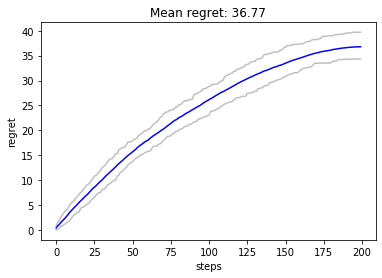

In [18]:
plt.plot(cum_regret.mean(axis=0), color='blue')
plt.plot(np.quantile(cum_regret, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(cum_regret, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()